In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import os
import h5py
from dataclasses import dataclass
from typing import List
import datetime
import scipy.interpolate
from scipy.special import lambertw
import lmfit
from tqdm import tqdm

In [2]:
N_CORES = os.cpu_count()
N_CORES

6

In [17]:
@dataclass
class LossSample:
    loss: np.ndarray
    loss_t: np.ndarray
    loss_timestamp: np.ndarray

    intensity: np.ndarray
    intensity_t: np.ndarray
    intensity_timestamp: np.ndarray

    angle: float
    wire: bool
    octupole: bool

In [18]:
def take_from_peak(times, losses):
    peak_index = np.argmax(losses)
    return times[peak_index:], losses[peak_index:]

In [19]:
data_path = "/eos/project-d/da-and-diffusion-studies/Wire_Compensator_Studies/DATA_MD/"

In [20]:
summ_plot_df = pd.read_pickle(data_path+'summary_plot_data.pkl')

In [21]:
summ_plot_df["datetime"] = summ_plot_df.index.to_pydatetime()

In [22]:
summ_plot_df["seconds"] = summ_plot_df["datetime"].apply(
    lambda x: (x - summ_plot_df["datetime"].iloc[0]).total_seconds()
)

In [23]:
# Crossing angle

T0 = summ_plot_df.index[0].to_pydatetime()
T0bis = pd.Timestamp('2018-10-29 11:08:00.000000000+00:00', tz='CET').to_pydatetime()
T1 = pd.Timestamp('2018-10-29 11:43:29.887000084+00:00', tz='CET').to_pydatetime()
T2 = pd.Timestamp('2018-10-29 12:04:57.258000135+00:00', tz='CET').to_pydatetime()
T3 = pd.Timestamp('2018-10-29 12:23:33.439000130+00:00', tz='CET').to_pydatetime()
T3bis = pd.Timestamp('2018-10-29 13:00:33.439000130+00:00', tz='CET').to_pydatetime()
T4 = summ_plot_df.index[-1].to_pydatetime()

/home/camontan/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: UserWarning: Discarding nonzero nanoseconds in conversion.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
# Crossing angle

T0 = summ_plot_df.index[0].to_pydatetime()
T0bis = pd.Timestamp('2018-10-29 11:08:00.000000000+00:00', tz='CET').to_pydatetime()

T1_from = pd.Timestamp('2018-10-29 11:43:06.000000000+00:00', tz='CET').to_pydatetime()
T1 = pd.Timestamp('2018-10-29 11:43:29.887000084+00:00', tz='CET').to_pydatetime()
T1_to = pd.Timestamp('2018-10-29 11:44:01.000000000+00:00', tz='CET').to_pydatetime()

T2_from = pd.Timestamp('2018-10-29 12:04:57.000000000+00:00', tz='CET').to_pydatetime()
T2 = pd.Timestamp('2018-10-29 12:04:57.258000135+00:00', tz='CET').to_pydatetime()
T2_to = pd.Timestamp('2018-10-29 12:05:21.000000000+00:00', tz='CET').to_pydatetime()

T3_from = pd.Timestamp('2018-10-29 12:23:21.000000000+00:00', tz='CET').to_pydatetime()
T3 = pd.Timestamp('2018-10-29 12:23:33.439000130+00:00', tz='CET').to_pydatetime()
T3_to = pd.Timestamp('2018-10-29 12:24:02.000000000+00:00', tz='CET').to_pydatetime()

T3bis = pd.Timestamp('2018-10-29 13:00:33.439000130+00:00', tz='CET').to_pydatetime()
T4 = summ_plot_df.index[-1].to_pydatetime()

In [25]:
def classify_angle(t):
    if t < T0bis:
        return -1.0
    if t < T1:
        return 160.0
    elif t < T2:
        return 150.0
    elif t < T3:
        return 140.0
    else:
        return 130.0

In [26]:
def classify_angle_seconds(s):
    if s < (T0bis - T0).total_seconds():
        return -1.0
    if s < (T1 - T0).total_seconds():
        return 160.0
    elif s < (T2 - T0).total_seconds():
        return 150.0
    elif s < (T3 - T0).total_seconds():
        return 140.0
    else:
        return 130.0

In [27]:
def classify_angle_transient(t):
    if t < T0bis:
        return -1.0
    if t < T1_from:
        return 160.0
    elif t < T1_to:
        return -1.0
    elif t < T2_from:
        return 150.0
    elif t < T2_to:
        return -1.0
    elif t < T3_from:
        return 140.0
    elif t < T3_to:
        return -1
    else:
        return 130.0

In [28]:
def classify_angle_seconds_transient(s):
    if s < (T0bis - T0).total_seconds():
        return -1.0
    if s < (T1_from - T0).total_seconds():
        return 160.0
    elif s < (T1_to - T0).total_seconds():
        return -1.0
    elif s < (T2_from - T0).total_seconds():
        return 150.0
    elif s < (T2_to - T0).total_seconds():
        return -1.0
    elif s < (T3_from - T0).total_seconds():
        return 140.0
    elif s < (T3_to - T0).total_seconds():
        return -1.0
    else:
        return 130.0

In [29]:
summ_plot_df.columns

Index(['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY', 'LHC.BCTDC.A6R4.B2:BEAM_INTENSITY',
       'LHC.BLM.LIFETIME:B1_BEAM_LIFETIME',
       'LHC.BLM.LIFETIME:B1_CALIBRATED_LOSS', 'LHC.BLM.LIFETIME:B1_LOSS_KW',
       'LHC.BLM.LIFETIME:B2_BEAM_LIFETIME',
       'LHC.BLM.LIFETIME:B2_CALIBRATED_LOSS', 'LHC.BLM.LIFETIME:B2_LOSS_KW',
       'LHC.BLM.LIFETIME:LUMINOSITY_LOSS', 'LHC.RUNCONFIG:IP1-XING-V-MURAD',
       'LHC.RUNCONFIG:IP2-XING-V-MURAD', 'LHC.RUNCONFIG:IP5-XING-H-MURAD',
       'LHC.RUNCONFIG:IP8-XING-H-MURAD', 'RPMBB.RR17.ROF.A12B1:I_MEAS',
       'RPMBB.RR17.ROF.A12B2:I_MEAS', 'RPMC.UL14.RBBCW.L1B2:I_MEAS',
       'RPMC.UL16.RBBCW.R1B2:I_MEAS', 'RPMC.UL557.RBBCW.R5B2:I_MEAS',
       'RPMC.USC55.RBBCW.L5B2:I_MEAS', 'datetime', 'seconds'],
      dtype='object')

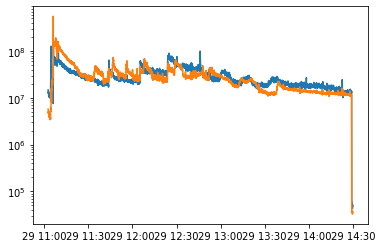

In [30]:
plt.plot(summ_plot_df["LHC.BLM.LIFETIME:B1_CALIBRATED_LOSS"].dropna())
plt.plot(summ_plot_df["LHC.BLM.LIFETIME:B2_CALIBRATED_LOSS"].dropna())

plt.yscale("log")

In [31]:
wire_f = scipy.interpolate.interp1d(
    summ_plot_df["seconds"][summ_plot_df["RPMC.UL16.RBBCW.R1B2:I_MEAS"].notna()],
    summ_plot_df["RPMC.UL16.RBBCW.R1B2:I_MEAS"].dropna(),
    bounds_error=False,
    fill_value=0.0
)

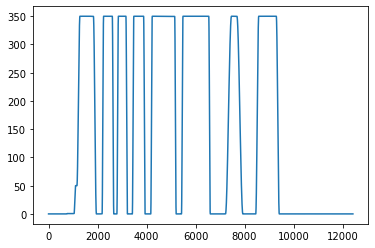

In [32]:
x = np.linspace(summ_plot_df["seconds"].iloc[0], summ_plot_df["seconds"].iloc[-1], 10000)
plt.plot(x, wire_f(x))

In [33]:
intensity_b1 = scipy.interpolate.interp1d(
    summ_plot_df["seconds"][summ_plot_df['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'].notna()],
    summ_plot_df['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'].dropna(),
    bounds_error=False,
    fill_value=summ_plot_df['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'].dropna().iloc[0]
)

In [34]:
intensity_b2 = scipy.interpolate.interp1d(
    summ_plot_df["seconds"][summ_plot_df['LHC.BCTDC.A6R4.B2:BEAM_INTENSITY'].notna()],
    summ_plot_df['LHC.BCTDC.A6R4.B2:BEAM_INTENSITY'].dropna(),
    bounds_error=False,
    fill_value=summ_plot_df['LHC.BCTDC.A6R4.B2:BEAM_INTENSITY'].dropna().iloc[0]
)

In [37]:
def classify_wire(x, low_bound=10.0, high_bound=340.0):
    if wire_f(x) < low_bound:
        return 0
    elif wire_f(x) > high_bound:
        return 1
    else:
        return -1

In [38]:
print(wire_f(7000))
classify_wire(7000)

0.011988732130186072


0

In [39]:
octo_f = scipy.interpolate.interp1d(
    summ_plot_df["seconds"][summ_plot_df["RPMBB.RR17.ROF.A12B2:I_MEAS"].notna()],
    summ_plot_df["RPMBB.RR17.ROF.A12B2:I_MEAS"].dropna(),
    bounds_error=False,
    fill_value=np.nanmax(summ_plot_df["RPMBB.RR17.ROF.A12B2:I_MEAS"].dropna())
)

263.65765
-564.9797


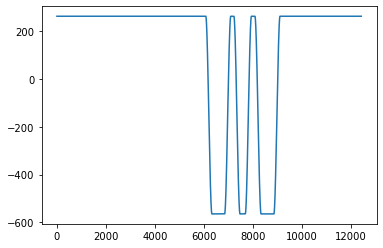

In [40]:
x = np.linspace(summ_plot_df["seconds"].iloc[0], summ_plot_df["seconds"].iloc[-1], 10000)
plt.plot(x, octo_f(x))
print(np.nanmax(summ_plot_df["RPMBB.RR17.ROF.A12B2:I_MEAS"].dropna()))
print(np.nanmin(summ_plot_df["RPMBB.RR17.ROF.A12B2:I_MEAS"].dropna()))

In [41]:
def classify_octo(x, low_bound=-550.0, high_bound=250.0):
    if octo_f(x) < low_bound:
        return 0
    elif octo_f(x) > high_bound:
        return 1
    else:
        return -1

In [42]:
summ_plot_df["angle"] = summ_plot_df["seconds"].apply(classify_angle_seconds_transient)
summ_plot_df["wire"] = summ_plot_df["seconds"].apply(classify_wire)
summ_plot_df["octupole"] = summ_plot_df["seconds"].apply(classify_octo)

In [43]:
summ_plot_df["angle"]

2018-10-29 11:02:45.519999981+00:00     -1.0
2018-10-29 11:02:45.640000105+00:00     -1.0
2018-10-29 11:02:45.653000116+00:00     -1.0
2018-10-29 11:02:45.660000086+00:00     -1.0
2018-10-29 11:02:45.680000067+00:00     -1.0
                                       ...  
2018-10-29 14:29:46.680000067+00:00    130.0
2018-10-29 14:29:46.858000040+00:00    130.0
2018-10-29 14:29:47+00:00              130.0
2018-10-29 14:29:47.019999981+00:00    130.0
2018-10-29 14:29:47.140000105+00:00    130.0
Name: angle, Length: 149113, dtype: float64

In [44]:
def replace_minus_1(x: np.ndarray):
    x = x.copy()
    for i, v in enumerate(x):
        if v == -1.0:
            if i == 0:
                x[i] = x[i]
            else:
                x[i] = x[i - 1]
    return x

In [45]:
summ_plot_df["angle_contiguos"] = replace_minus_1(summ_plot_df["angle"].to_numpy())
summ_plot_df["wire_contiguos"] = replace_minus_1(summ_plot_df["wire"].to_numpy())
summ_plot_df["octupole_contiguos"] = replace_minus_1(summ_plot_df["octupole"].to_numpy())

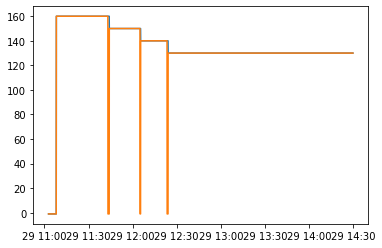

In [46]:
plt.plot(summ_plot_df["angle_contiguos"])
plt.plot(summ_plot_df["angle"])

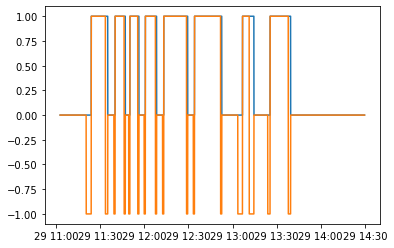

In [47]:
plt.plot(summ_plot_df["wire_contiguos"])
plt.plot(summ_plot_df["wire"])

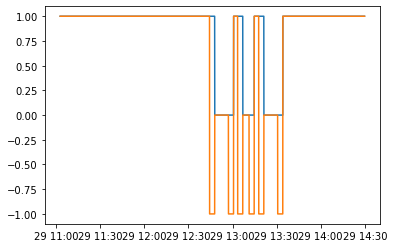

In [48]:
# plt.plot(summ_plot_df["angle"])
# plt.twinx()
plt.plot(summ_plot_df["octupole_contiguos"])
plt.plot(summ_plot_df["octupole"])

In [49]:
selected_columns = summ_plot_df[["angle", "wire", "octupole"]]

In [50]:
cumsum = (selected_columns != selected_columns.shift()).cumsum()
cumsum["sum"] = cumsum.sum(axis=1)
cumsum["sum"]

2018-10-29 11:02:45.519999981+00:00     3
2018-10-29 11:02:45.640000105+00:00     3
2018-10-29 11:02:45.653000116+00:00     3
2018-10-29 11:02:45.660000086+00:00     3
2018-10-29 11:02:45.680000067+00:00     3
                                       ..
2018-10-29 14:29:46.680000067+00:00    54
2018-10-29 14:29:46.858000040+00:00    54
2018-10-29 14:29:47+00:00              54
2018-10-29 14:29:47.019999981+00:00    54
2018-10-29 14:29:47.140000105+00:00    54
Name: sum, Length: 149113, dtype: int64

In [51]:
loss_list_b1 = []
loss_list_b2 = []

for i, g in summ_plot_df.groupby([cumsum["sum"]]):
    if g["octupole"].iloc[0] == -1.0:
        continue
    if g["angle"].iloc[0] == -1.0:
        continue

    loss_list_b1.append(
        LossSample(
            loss=g["LHC.BLM.LIFETIME:B1_CALIBRATED_LOSS"].dropna().to_numpy(),
            loss_t=g[g["LHC.BLM.LIFETIME:B1_CALIBRATED_LOSS"].notnull()]["seconds"].to_numpy(),
            loss_timestamp=g[g["LHC.BLM.LIFETIME:B1_CALIBRATED_LOSS"].notnull()]["datetime"].to_numpy(),

            intensity=g['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'].dropna().to_numpy(),
            intensity_t=g[g['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'].notnull()]["seconds"].to_numpy(),
            intensity_timestamp=g[g['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'].notnull()]["datetime"].to_numpy(),

            angle=g["angle"].dropna().to_numpy()[0],
            wire=False,
            octupole=bool(g["octupole"].dropna().to_numpy()[0])
        )
    )

    if g["wire"].iloc[0] == -1:
        continue

    loss_list_b2.append(
        LossSample(
            loss=g["LHC.BLM.LIFETIME:B2_CALIBRATED_LOSS"].dropna().to_numpy(),
            loss_t=g[g["LHC.BLM.LIFETIME:B2_CALIBRATED_LOSS"].notnull()]["seconds"].to_numpy(),
            loss_timestamp=g[g["LHC.BLM.LIFETIME:B2_CALIBRATED_LOSS"].notnull()]["datetime"].to_numpy(),

            intensity=g['LHC.BCTDC.A6R4.B2:BEAM_INTENSITY'].dropna().to_numpy(),
            intensity_t=g[g['LHC.BCTDC.A6R4.B2:BEAM_INTENSITY'].notnull()]["seconds"].to_numpy(),
            intensity_timestamp=g[g['LHC.BCTDC.A6R4.B2:BEAM_INTENSITY'].notnull()]["datetime"].to_numpy(),

            angle=g["angle"].dropna().to_numpy()[0],
            wire=bool(g["wire"].dropna().to_numpy()[0]),
            octupole=bool(g["octupole"].dropna().to_numpy()[0])
        )
    )

In [52]:
for b in loss_list_b1:
    print("wire:", b.wire, "\toctupole:", b.octupole, " \tangle:", b.angle)

wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 140.0
wire: False 	octupole: True  	angle: 140.0
wire: False 	octupole: True  	angle: 140.0
wire: False 	octupole: True  	angle: 140.0
wire: False 	octupole: True  	angle: 140.0
wire: False 	octupole: True  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: False

In [53]:
for b in loss_list_b2:
    print("wire:", b.wire, "\toctupole:", b.octupole, " \tangle:", b.angle)

wire: False 	octupole: True  	angle: 160.0
wire: True 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: True 	octupole: True  	angle: 160.0
wire: True 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: True 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: True 	octupole: True  	angle: 150.0
wire: True 	octupole: True  	angle: 140.0
wire: False 	octupole: True  	angle: 140.0
wire: True 	octupole: True  	angle: 140.0
wire: True 	octupole: True  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: True 	octupole: True  	angle: 130.0
wire: True 	octupole: False  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: True 	octupole: False  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: True 	octupole: False  	angle: 130.0
wire: True 	octupole: True  	angle: 130.0
wire: False 	octupo

In [54]:
selected_columns = summ_plot_df[["angle_contiguos", "wire_contiguos", "octupole_contiguos"]]


In [55]:
cumsum = (selected_columns != selected_columns.shift()).cumsum()
cumsum["sum"] = cumsum.sum(axis=1)
cumsum["sum"]

2018-10-29 11:02:45.519999981+00:00     3
2018-10-29 11:02:45.640000105+00:00     3
2018-10-29 11:02:45.653000116+00:00     3
2018-10-29 11:02:45.660000086+00:00     3
2018-10-29 11:02:45.680000067+00:00     3
                                       ..
2018-10-29 14:29:46.680000067+00:00    29
2018-10-29 14:29:46.858000040+00:00    29
2018-10-29 14:29:47+00:00              29
2018-10-29 14:29:47.019999981+00:00    29
2018-10-29 14:29:47.140000105+00:00    29
Name: sum, Length: 149113, dtype: int64

In [56]:
loss_list_cont_b1 = []
loss_list_cont_b2 = []

for i, g in summ_plot_df.groupby([cumsum["sum"]]):
    if g["octupole_contiguos"].iloc[0] == -1:
        continue
    if g["angle_contiguos"].iloc[0] == -1.0:
        continue

    loss_list_cont_b1.append(
        LossSample(
            loss=g["LHC.BLM.LIFETIME:B1_CALIBRATED_LOSS"].dropna().to_numpy(),
            loss_t=g[g["LHC.BLM.LIFETIME:B1_CALIBRATED_LOSS"].notnull()]["seconds"].to_numpy(),
            loss_timestamp=g[g["LHC.BLM.LIFETIME:B1_CALIBRATED_LOSS"].notnull()]["datetime"].to_numpy(),

            intensity=g['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'].dropna().to_numpy(),
            intensity_t=g[g['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'].notnull()]["seconds"].to_numpy(),
            intensity_timestamp=g[g['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'].notnull()]["datetime"].to_numpy(),

            angle=g["angle_contiguos"].dropna().to_numpy()[0],
            wire=False,
            octupole=bool(g["octupole_contiguos"].dropna().to_numpy()[0])
        )
    )

    if g["wire_contiguos"].iloc[0] == -1:
        continue

    loss_list_cont_b2.append(
        LossSample(
            loss=g["LHC.BLM.LIFETIME:B2_CALIBRATED_LOSS"].dropna().to_numpy(),
            loss_t=g[g["LHC.BLM.LIFETIME:B2_CALIBRATED_LOSS"].notnull()]["seconds"].to_numpy(),
            loss_timestamp=g[g["LHC.BLM.LIFETIME:B2_CALIBRATED_LOSS"].notnull()]["datetime"].to_numpy(),

            intensity=g['LHC.BCTDC.A6R4.B2:BEAM_INTENSITY'].dropna().to_numpy(),
            intensity_t=g[g['LHC.BCTDC.A6R4.B2:BEAM_INTENSITY'].notnull()]["seconds"].to_numpy(),
            intensity_timestamp=g[g['LHC.BCTDC.A6R4.B2:BEAM_INTENSITY'].notnull()]["datetime"].to_numpy(),

            angle=g["angle_contiguos"].dropna().to_numpy()[0],
            wire=bool(g["wire_contiguos"].dropna().to_numpy()[0]),
            octupole=bool(g["octupole_contiguos"].dropna().to_numpy()[0])
        )
    )

In [57]:
for b in loss_list_cont_b1:
    print("wire:", b.wire, "\toctupole:", b.octupole, " \tangle:", b.angle)

wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 140.0
wire: False 	octupole: True  	angle: 140.0
wire: False 	octupole: True  	angle: 140.0
wire: False 	octupole: True  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: 

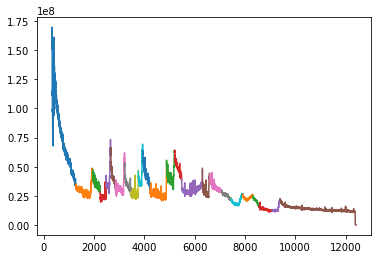

In [64]:
for b in loss_list_cont_b2:
    plt.plot(b.loss_t, b.loss, label=str(b.angle))

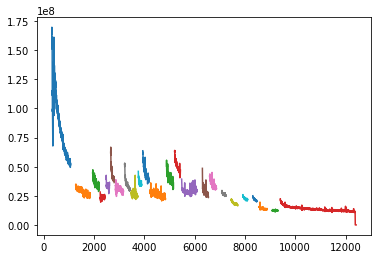

In [65]:
for b in loss_list_b2:
    plt.plot(b.loss_t, b.loss, label=str(b.angle))

In [60]:
for b in loss_list_cont_b2:
    print("wire:", b.wire, "\toctupole:", b.octupole, " \tangle:", b.angle)

wire: False 	octupole: True  	angle: 160.0
wire: True 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: True 	octupole: True  	angle: 160.0
wire: True 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: True 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: True 	octupole: True  	angle: 150.0
wire: True 	octupole: True  	angle: 140.0
wire: False 	octupole: True  	angle: 140.0
wire: True 	octupole: True  	angle: 140.0
wire: True 	octupole: True  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: True 	octupole: True  	angle: 130.0
wire: True 	octupole: False  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: True 	octupole: True  	angle: 130.0
wire: True 	octupole: False  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: True 	octupo

In [61]:
TURNS_PER_SECOND = 11245.0

In [62]:
from scipy.special import lambertw

In [63]:
def relative_wrap(n, d_func, **kwargs):
    return 1 - (1 + np.power(d_func(n, **kwargs), 2)) * np.exp(-np.power(d_func(n, **kwargs), 2))


In [71]:
def model_2(n, rho, kappa):
    return rho * np.power(kappa / (2 * np.exp(1)), kappa) * np.power(1 / np.log(n), kappa)

def wrap_2(n, rho, kappa):
    return relative_wrap(n, model_2, rho=rho, kappa=kappa)

def wrap_2_d(n, rho, kappa):
    return 2*kappa*rho**2*(kappa*np.exp(-1)/2)**(2*kappa)*(-rho**2*(kappa*np.exp(-1)/2)**(2*kappa)/np.log(n)**(2*kappa) - 1)*np.exp(-rho**2*(kappa*np.exp(-1)/2)**(2*kappa)/np.log(n)**(2*kappa)) / \
        (n*np.log(n)*np.log(n)**(2*kappa)) + 2*kappa*rho**2*(kappa*np.exp(-1)/2)**(2*kappa) * \
        np.exp(-rho**2*(kappa*np.exp(-1)/2)**(2*kappa)/np.log(n)
               ** (2*kappa))/(n*np.log(n)*np.log(n)**(2*kappa))

In [72]:
def model_4(n, rho, kappa):
    return rho * np.power(
        -np.exp(1) * lambertw(
            -(1 / (np.exp(1))) * np.power(rho / 6, 1 / kappa) * np.power(n * 8 / 7, -2/kappa),
            -1
        ),
        -kappa)

def wrap_4(n, rho, kappa):
    return relative_wrap(n, model_4, rho=rho, kappa=kappa)

def wrap_4_d(n, rho, kappa):
    result = -4*rho**2*(-rho**2/(-np.exp(1)*lambertw(-(rho/6)**(1/kappa)*np.exp(-1)/(8*n/7)**(2/kappa), -1))**(2*kappa) - 1)*np.exp(-rho**2/(-np.exp(1)*lambertw(-(rho/6)**(1/kappa)*np.exp(-1)/(8*n/7)**(2/kappa), -1))**(2*kappa))/(n*(-np.exp(1)*lambertw(-(rho/6)**(1/kappa)*np.exp(-1)/(8*n/7)**(2/kappa), -1))**(2*kappa)*(lambertw(-(rho/6) ** (1/kappa)*np.exp(-1)/(8*n/7)**(2/kappa), -1) + 1)) - 4*rho**2*np.exp(-rho**2/(-np.exp(1)*lambertw(-(rho/6)**(1/kappa)*np.exp(-1)/(8*n/7)**(2/kappa), -1))**(2*kappa))/(n*(-np.exp(1)*lambertw(-(rho/6)**(1/kappa)*np.exp(-1)/(8*n/7)**(2/kappa), -1))**(2*kappa)*(lambertw(-(rho/6)**(1/kappa)*np.exp(-1)/(8*n/7)**(2/kappa), -1) + 1))
    return result.real

In [82]:
def resid(params, x, y, model="model_4"):
    rho = params['rho'].value
    kappa = params['kappa'].value
    a = params['a'].value
    if model == "model_4":
        model = wrap_4_d(x + a, rho, kappa)
    elif model == "model_2":
        model = wrap_2_d(x + a, rho, kappa)
    else:
        raise ValueError("Model not recognized")
    # keep real part of model only
    model = model.real
    if np.isnan(model).any():
        print(rho, kappa, a)
        return y + 1e10
    return y + model

In [67]:
def fit_data(seconds, loss, intensity, n0=2, vary_a=False, method="leastsq", rho0=100.0, kappa0=0.75):
    # init parameters for lmfit
    params = lmfit.Parameters()
    params.add('rho', value=rho0, min=0)
    params.add('kappa', value=kappa0, min=0.01)
    params.add('a', value=0, vary=vary_a, min=0)

    # prepare the loss data
    turns = seconds * TURNS_PER_SECOND
    y = (loss / intensity) / TURNS_PER_SECOND

    # set the offset
    turns -= turns[0]
    turns += n0

    # fit the data
    result = lmfit.minimize(resid, params, args=(turns, y), method=method)
    return result, turns, y

In [68]:
def fit_data_brute(seconds, loss, intensity, n0=2, vary_a=False, rho_range=(10.0, 200.0), kappa_range=(0.2, 1.0)):
    # init parameters for lmfit
    params = lmfit.Parameters()
    params.add('rho', value=rho_range[0], min=rho_range[0], max=rho_range[1])
    params.add('kappa', value=kappa_range[0], min=kappa_range[0], max=kappa_range[1])
    params.add('a', value=0, vary=vary_a, min=0)

    # prepare the loss data
    turns = seconds * TURNS_PER_SECOND
    y = (loss / intensity) / TURNS_PER_SECOND

    # set the offset
    turns -= turns[0]
    turns += n0

    # fit the data
    result = lmfit.minimize(resid, params, args=(turns, y), method="brute", Ns=51, workers=N_CORES)

    _, d_rho = np.linspace(rho_range[0], rho_range[1], 51, retstep=True)
    _, d_kappa = np.linspace(kappa_range[0], kappa_range[1], 51, retstep=True)

    params_brute = lmfit.Parameters()
    params_brute.add('rho', value=result.params['rho'].value, min=rho_range[0]-d_rho, max=rho_range[1]+d_rho)
    params_brute.add('kappa', value=result.params['kappa'].value, min=kappa_range[0]-d_kappa, max=kappa_range[1]+d_kappa)
    params_brute.add('a', value=0, vary=vary_a, min=0)

    # print("Brute")
    # print("rho: ", result.params['rho'].value, ". Bounds:", result.params['rho'].value - d_rho, result.params['rho'].value + d_rho)
    # print("kappa: ", result.params['kappa'].value, ". Bounds:", result.params['kappa'].value - d_kappa, result.params['kappa'].value + d_kappa)

    # fit the data
    result_brute = lmfit.minimize(resid, params_brute, args=(turns, y))

    # print("Refined")
    # print("rho: ", result_brute.params['rho'].value, "+-", result_brute.params['rho'].stderr)
    # print("kappa: ", result_brute.params['kappa'].value, "+-", result_brute.params['kappa'].stderr)
    
    return result_brute, turns, y

In [55]:
best_fits_b1 = pd.DataFrame(
    columns=["angle", "rho", "kappa", "n0", "chisq"]
)
best_fits_b1

,angle,rho,kappa,n0,chisq


In [62]:
import pickle

In [63]:
with open("loss_list_b2.pkl", "wb") as f:
    pickle.dump(loss_list_b2, f)

with open("loss_list_cont_b2.pkl", "wb") as f:
    pickle.dump(loss_list_cont_b2, f)

In [64]:
t = np.array([])
loss = np.array([])

for b in loss_list_b1:
    if b.angle==160.0:
        t = np.concatenate((t, b.loss_t))
        loss = np.concatenate((loss, b.loss))

intensity = intensity_b1(t[0])

with open("b1_160.pkl", 'wb') as f:
    pickle.dump((t * TURNS_PER_SECOND, loss / TURNS_PER_SECOND, intensity), f)

In [65]:
t = np.array([])
loss = np.array([])

for b in loss_list_b1:
    if b.angle==150.0:
        t = np.concatenate((t, b.loss_t))
        loss = np.concatenate((loss, b.loss))

intensity = intensity_b1(t[0])

with open("b1_150.pkl", 'wb') as f:
    pickle.dump((t * TURNS_PER_SECOND, loss / TURNS_PER_SECOND, intensity), f)


In [66]:
t = np.array([])
loss = np.array([])

for b in loss_list_b1:
    if b.angle==140.0:
        t = np.concatenate((t, b.loss_t))
        loss = np.concatenate((loss, b.loss))

intensity = intensity_b1(t[0])

with open("b1_140.pkl", 'wb') as f:
    pickle.dump((t * TURNS_PER_SECOND, loss / TURNS_PER_SECOND, intensity), f)


In [67]:
t = np.array([])
loss = np.array([])

for b in loss_list_b1:
    if b.angle==130.0:
        t = np.concatenate((t, b.loss_t))
        loss = np.concatenate((loss, b.loss))

intensity = intensity_b1(t[0])

with open("b1_130.pkl", 'wb') as f:
    pickle.dump((t * TURNS_PER_SECOND, loss / TURNS_PER_SECOND, intensity), f)


In [68]:
t = np.array([])
loss = np.array([])

for b in loss_list_b1:
    if b.angle==160.0:
        t = np.concatenate((t, b.loss_t))
        loss = np.concatenate((loss, b.loss))

intensity = intensity_b1(t[0])

100%|██████████| 4/4 [00:00<00:00, 37.66it/s]


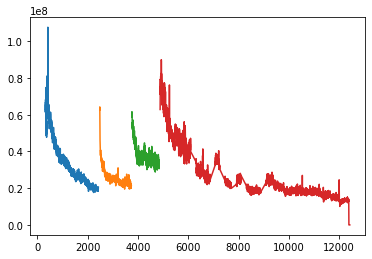

In [69]:
for angle in tqdm([160.0, 150.0, 140.0, 130.0]):
    t = np.array([])
    loss = np.array([])
    for b in loss_list_b1:
        if b.angle==angle:
            t = np.concatenate((t, b.loss_t))
            loss = np.concatenate((loss, b.loss))
    plt.plot(t, loss)

In [83]:
result_main_list = []
n0_values = np.logspace(1, 1, 1) 

for angle in tqdm([160.0, 150.0, 140.0, 130.0]):
    t = np.array([])
    loss = np.array([])
    for b in loss_list_b1:
        if b.angle==angle:
            t = np.concatenate((t, b.loss_t))
            loss = np.concatenate((loss, b.loss))

    #t, loss = take_from_peak(t, loss)

    intensity = intensity_b1(t[0])
    result_list = []
    for n0 in tqdm(n0_values):
        # try:
            result, turns, y = fit_data_brute(t, loss, intensity, n0=n0, vary_a=False)
            result_list.append((result, turns, y))
        # except Exception as e:
        #     print("Failed to fit data for n0 = {}".format(n0))
        #     result_list.append((None, None, None))
    
    result_main_list.append(result_list)

100%|██████████| 4/4 [00:33<00:00,  8.43s/it]


In [84]:
best_fits_2 = []
for rm in result_main_list:
    chi_sqr_list = []
    for r in rm:
        chi_sqr_list.append(r[0].chisqr)

    best_idx = np.argmin(chi_sqr_list)
    best_fits_2.append({
        "lmfit": rm[best_idx][0],
        "xdata": rm[best_idx][1],
        "ydata": rm[best_idx][2],
        "resid": rm[best_idx][2] - rm[best_idx][0].residual,
        "rho": rm[best_idx][0].params['rho'].value,
        "kappa": rm[best_idx][0].params['kappa'].value,
        "n0": n0_values[best_idx],
        "chisq": chi_sqr_list[best_idx],
        "redchi": rm[best_idx][0].redchi
    })

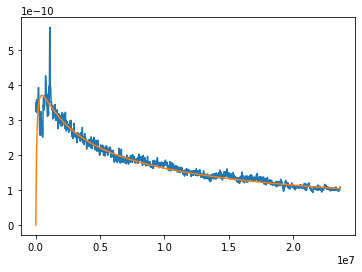

In [85]:
plt.plot(best_fits_2[0]["xdata"], best_fits_2[0]["ydata"], label="data")
plt.plot(best_fits_2[0]["xdata"], best_fits_2[0]["ydata"] - best_fits_2[0]["lmfit"].residual, label="residual")

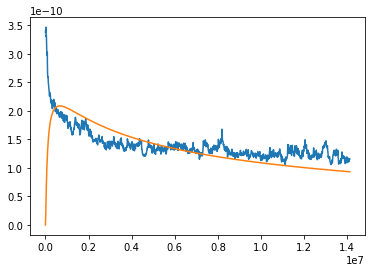

In [86]:
plt.plot(best_fits_2[1]["xdata"], best_fits_2[1]["ydata"], label="data")
plt.plot(best_fits_2[1]["xdata"], best_fits_2[1]["ydata"] - best_fits_2[1]["lmfit"].residual, label="residual")

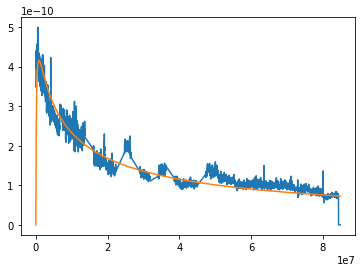

In [87]:
plt.plot(best_fits_2[-1]["xdata"], best_fits_2[-1]["ydata"], label="data")
plt.plot(best_fits_2[-1]["xdata"], best_fits_2[-1]["ydata"] - best_fits_2[-1]["lmfit"].residual, label="residual")

In [88]:
best_fits_2_b1 = pd.DataFrame(
    columns=["wire", "angle", "rho", "kappa", "n0", "chisq", "redchi"]
)
best_fits_2_b1

,wire,angle,rho,kappa,n0,chisq,redchi


In [89]:
for d, b in zip([160.0, 150.0, 140.0, 130.0], best_fits_2):
    best_fits_2_b1 = best_fits_2_b1.append({
        "wire": False,
        "angle": d,
        "rho": b["rho"],
        "kappa": b["kappa"],
        "n0": b["n0"],
        "chisq": b["chisq"],
        "redchi": b["redchi"]
    }, ignore_index=True)

/tmp/ipykernel_37486/2645112626.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_fits_2_b1 = best_fits_2_b1.append({
/tmp/ipykernel_37486/2645112626.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_fits_2_b1 = best_fits_2_b1.append({
/tmp/ipykernel_37486/2645112626.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_fits_2_b1 = best_fits_2_b1.append({
/tmp/ipykernel_37486/2645112626.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_fits_2_b1 = best_fits_2_b1.append({


In [90]:
best_fits_2_b1

,wire,angle,rho,kappa,n0,chisq,redchi
0,False,160.0,107.16316,0.756383,10.0,0.0,0.0
1,False,150.0,109.576983,0.754399,10.0,0.0,0.0
2,False,140.0,133.074527,0.811983,10.0,0.0,0.0
3,False,130.0,154.894899,0.860383,10.0,0.0,0.0


In [91]:
result_main_list = []
n0_values = np.logspace(1, 8, 30) 

for angle in tqdm([160.0, 150.0, 140.0, 130.0]):
    t = np.array([])
    loss = np.array([])
    for b in loss_list_b1:
        if b.angle==angle:
            t = np.concatenate((t, b.loss_t))
            loss = np.concatenate((loss, b.loss))

    #t, loss = take_from_peak(t, loss)

    intensity = intensity_b1(t[0])
    result_list = []
    for n0 in tqdm(n0_values):
        # try:
            result, turns, y = fit_data_brute(t, loss, intensity, n0=n0, vary_a=False)
            result_list.append((result, turns, y))
        # except Exception as e:
        #     print("Failed to fit data for n0 = {}".format(n0))
        #     result_list.append((None, None, None))
    
    result_main_list.append(result_list)

100%|██████████| 4/4 [17:01<00:00, 255.35s/it]


In [65]:
best_fits_3 = []
for rm in result_main_list:
    chi_sqr_list = []
    for r in rm:
        chi_sqr_list.append(r[0].chisqr)

    best_idx = np.argmin(chi_sqr_list)
    best_fits_3.append({
        "lmfit": rm[best_idx][0],
        "xdata": rm[best_idx][1],
        "ydata": rm[best_idx][2],
        "resid": rm[best_idx][2] - rm[best_idx][0].residual,
        "rho": rm[best_idx][0].params['rho'].value,
        "kappa": rm[best_idx][0].params['kappa'].value,
        "n0": n0_values[best_idx],
        "chisq": chi_sqr_list[best_idx],
        "redchi": rm[best_idx][0].redchi
    })

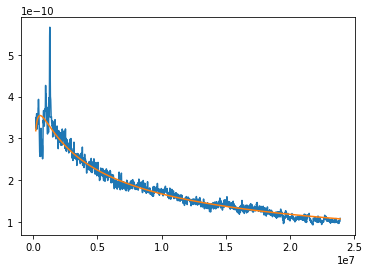

In [66]:
plt.plot(best_fits_3[0]["xdata"], best_fits_3[0]["ydata"], label="data")
plt.plot(best_fits_3[0]["xdata"], best_fits_3[0]["ydata"] - best_fits_3[0]["lmfit"].residual, label="residual")

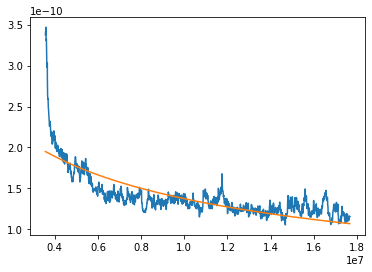

In [81]:
plt.plot(best_fits_3[1]["xdata"], best_fits_3[1]["ydata"], label="data")
plt.plot(best_fits_3[1]["xdata"], best_fits_3[1]["ydata"] - best_fits_3[1]["lmfit"].residual, label="residual")

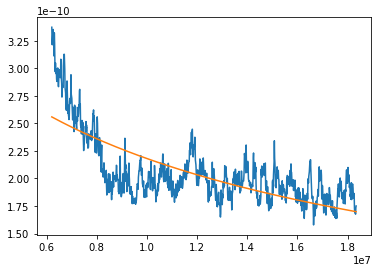

In [82]:
plt.plot(best_fits_3[2]["xdata"], best_fits_3[2]["ydata"], label="data")
plt.plot(best_fits_3[2]["xdata"], best_fits_3[2]["ydata"] - best_fits_3[2]["lmfit"].residual, label="residual")

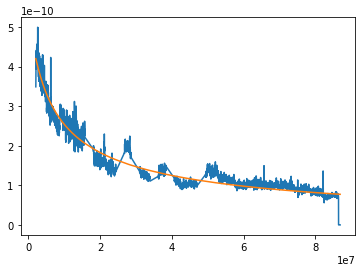

In [83]:
plt.plot(best_fits_3[3]["xdata"], best_fits_3[3]["ydata"], label="data")
plt.plot(best_fits_3[3]["xdata"], best_fits_3[3]["ydata"] - best_fits_3[3]["lmfit"].residual, label="residual")

In [67]:
best_fits_3_b1 = pd.DataFrame(
    columns=["wire", "angle", "rho", "kappa", "n0", "chisq", "redchi"]
)
best_fits_3_b1

,wire,angle,rho,kappa,n0,chisq,redchi


In [68]:
for d, b in zip([160.0, 150.0, 140.0, 130.0], best_fits_3):
    best_fits_3_b1 = best_fits_3_b1.append({
        "wire": False,
        "angle": d,
        "rho": b["rho"],
        "kappa": b["kappa"],
        "n0": b["n0"],
        "chisq": b["chisq"],
        "redchi": b["redchi"]
    }, ignore_index=True)

/tmp/ipykernel_86691/2635957853.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_fits_3_b1 = best_fits_3_b1.append({
/tmp/ipykernel_86691/2635957853.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_fits_3_b1 = best_fits_3_b1.append({
/tmp/ipykernel_86691/2635957853.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_fits_3_b1 = best_fits_3_b1.append({
/tmp/ipykernel_86691/2635957853.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_fits_3_b1 = best_fits_3_b1.append({


In [69]:
best_fits_3_b1

,wire,angle,rho,kappa,n0,chisq,redchi
0,False,160.0,115.262969,0.775773,221221.629107,0.0,0.0
1,False,150.0,131.905609,0.807038,3562247.890262,0.0,0.0
2,False,140.0,188.647983,0.911974,6210169.418916,0.0,0.0
3,False,130.0,159.349861,0.869844,2043359.717857,0.0,0.0


In [70]:
result_main_list = []
n0_values = np.logspace(1, 1, 1) 

for i, b in tqdm(enumerate(loss_list_b2[:-6]), total=len(loss_list_b2[:-6])):
    result_list = []
    t = np.array([])
    loss = np.array([])

    t = np.concatenate((t, b.loss_t))
    loss = np.concatenate((loss, b.loss))

    # if i <= 2:
    #     t, loss = take_from_peak(t, loss)

    intensity = intensity_b1(t[0])

    for n0 in n0_values:
        # try:
            result, turns, y = fit_data_brute(t, loss, intensity, n0=n0, vary_a=False)
            result_list.append((result, turns, y))
        # except Exception as e:
        #     print("Failed to fit data for n0 = {}".format(n0))
        #     result_list.append((None, None, None))
    
    result_main_list.append(result_list)

100%|██████████| 18/18 [00:17<00:00,  1.03it/s]


In [71]:
best_fits = []
for rm in result_main_list:
    chi_sqr_list = []
    for r in rm:
        chi_sqr_list.append(r[0].chisqr)

    best_idx = np.argmin(chi_sqr_list)
    best_fits.append({
        "lmfit": rm[best_idx][0],
        "xdata": rm[best_idx][1],
        "ydata": rm[best_idx][2],
        "resid": rm[best_idx][2] - rm[best_idx][0].residual,
        "rho": rm[best_idx][0].params['rho'].value,
        "kappa": rm[best_idx][0].params['kappa'].value,
        "n0": n0_values[best_idx],
        "chisq": chi_sqr_list[best_idx],
        "redchi": rm[best_idx][0].redchi
    })

In [72]:
best_fits_2_b2 = pd.DataFrame(
    columns=["wire", "angle", "rho", "kappa", "n0", "chisq", "redchi"]
)
best_fits_2_b2

,wire,angle,rho,kappa,n0,chisq,redchi


In [73]:
for d, b in zip(loss_list_b2, best_fits):
    best_fits_2_b2 = pd.concat([
        best_fits_2_b2, pd.DataFrame.from_records([{
            "wire": d.wire,
            "angle": d.angle,
            "rho": b["rho"],
            "kappa": b["kappa"],
            "n0": b["n0"],
            "chisq": b["chisq"],
            "redchi": b["redchi"]
        }])
    ], ignore_index=True)
    # best_fits_2_b2 = best_fits_2_b2.append({
    #     "wire": d.wire,
    #     "angle": d.angle,
    #     "rho": b["rho"],
    #     "kappa": b["kappa"],
    #     "n0": b["n0"],
    #     "chisq": b["chisq"],
    #     "redchi": b["redchi"]
    # }, ignore_index=True)

In [74]:
best_fits_2_b2

,wire,angle,rho,kappa,n0,chisq,redchi
0,False,160.0,107.513643,0.767191,10.0,0.0,0.0
1,True,160.0,111.407064,0.757131,10.0,0.0,0.0
2,False,160.0,73.346629,0.648472,10.0,0.0,0.0
3,True,160.0,83.661904,0.676303,10.0,0.0,0.0
4,True,150.0,64.041667,0.610717,10.0,0.0,0.0
5,False,150.0,54.701708,0.573883,10.0,0.0,0.0
6,True,150.0,102.151243,0.733773,10.0,0.0,0.0
7,False,150.0,61.799892,0.603605,10.0,0.0,0.0
8,True,150.0,92.885902,0.706395,10.0,0.0,0.0
9,True,140.0,58.817165,0.590151,10.0,0.0,0.0


In [75]:
result_main_list = []
n0_values = np.logspace(1, 8, 30) 

for i, b in tqdm(enumerate(loss_list_b2[:-6]), total=len(loss_list_b2[:-6])):
    result_list = []
    t = np.array([])
    loss = np.array([])

    t = np.concatenate((t, b.loss_t))
    loss = np.concatenate((loss, b.loss))

    # if i <= 2:
    #     t, loss = take_from_peak(t, loss)

    intensity = intensity_b1(t[0])

    for n0 in n0_values:
        # try:
            result, turns, y = fit_data_brute(t, loss, intensity, n0=n0, vary_a=False)
            result_list.append((result, turns, y))
        # except Exception as e:
        #     print("Failed to fit data for n0 = {}".format(n0))
        #     result_list.append((None, None, None))
    
    result_main_list.append(result_list)

100%|██████████| 18/18 [11:40<00:00, 38.90s/it]


In [76]:
best_fits = []
for rm in result_main_list:
    chi_sqr_list = []
    for r in rm:
        chi_sqr_list.append(r[0].chisqr)

    best_idx = np.argmin(chi_sqr_list)
    best_fits.append({
        "lmfit": rm[best_idx][0],
        "xdata": rm[best_idx][1],
        "ydata": rm[best_idx][2],
        "resid": rm[best_idx][2] - rm[best_idx][0].residual,
        "rho": rm[best_idx][0].params['rho'].value,
        "kappa": rm[best_idx][0].params['kappa'].value,
        "n0": n0_values[best_idx],
        "chisq": chi_sqr_list[best_idx],
        "redchi": rm[best_idx][0].redchi
    })

In [77]:
best_fits_3_b2 = pd.DataFrame(
    columns=["wire", "angle", "rho", "kappa", "n0", "chisq", "redchi"]
)
best_fits_3_b2

,wire,angle,rho,kappa,n0,chisq,redchi


In [78]:
for d, b in zip(loss_list_b2, best_fits):
    best_fits_3_b2 = pd.concat([
        best_fits_3_b2, pd.DataFrame.from_records([{
            "wire": d.wire,
            "angle": d.angle,
            "rho": b["rho"],
            "kappa": b["kappa"],
            "n0": b["n0"],
            "chisq": b["chisq"],
            "redchi": b["redchi"]
        }])
    ], ignore_index=True)
    # best_fits_2_b2 = best_fits_2_b2.append({
    #     "wire": d.wire,
    #     "angle": d.angle,
    #     "rho": b["rho"],
    #     "kappa": b["kappa"],
    #     "n0": b["n0"],
    #     "chisq": b["chisq"],
    #     "redchi": b["redchi"]
    # }, ignore_index=True)

In [79]:
best_fits_3_b2

,wire,angle,rho,kappa,n0,chisq,redchi
0,False,160.0,6.200001,0.438876,6210169.418916,0.0,0.0
1,True,160.0,171.495638,0.875023,2043359.717857,0.0,0.0
2,False,160.0,94.166934,0.717878,2043359.717857,0.0,0.0
3,True,160.0,200.018216,0.913552,1172102.297533,0.0,0.0
4,True,150.0,107.386027,0.752388,3562247.890262,0.0,0.0
5,False,150.0,56.92131,0.58758,672335.75365,0.0,0.0
6,True,150.0,186.740661,0.898536,1172102.297533,0.0,0.0
7,False,150.0,64.056494,0.616968,1172102.297533,0.0,0.0
8,True,150.0,154.75733,0.844405,672335.75365,0.0,0.0
9,True,140.0,87.420714,0.698024,2043359.717857,0.0,0.0


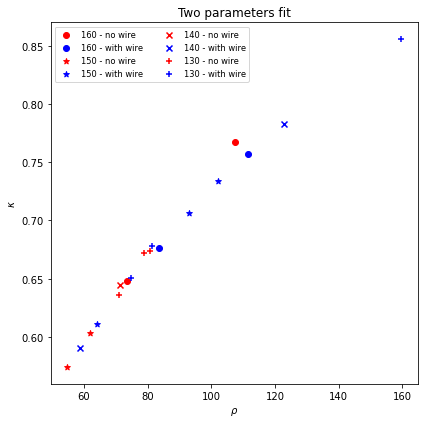

In [80]:
plt.figure(figsize=(6, 6))

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == False) & (best_fits_2_b2["angle"] == 160.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="o", label="160 - no wire")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == True) & (best_fits_2_b2["angle"] == 160.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="o", label="160 - with wire")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == False) & (best_fits_2_b2["angle"] == 150.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="*", label="150 - no wire")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == True) & (best_fits_2_b2["angle"] == 150.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="*", label="150 - with wire")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == False) & (best_fits_2_b2["angle"] == 140.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="x", label="140 - no wire")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == True) & (best_fits_2_b2["angle"] == 140.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="x", label="140 - with wire")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == False) & (best_fits_2_b2["angle"] == 130.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="+", label="130 - no wire")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == True) & (best_fits_2_b2["angle"] == 130.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="+", label="130 - with wire")

plt.legend(ncol=2, fontsize="small")
plt.xlabel("$\\rho$")
plt.ylabel("$\\kappa$")
plt.title("Two parameters fit")

plt.tight_layout()

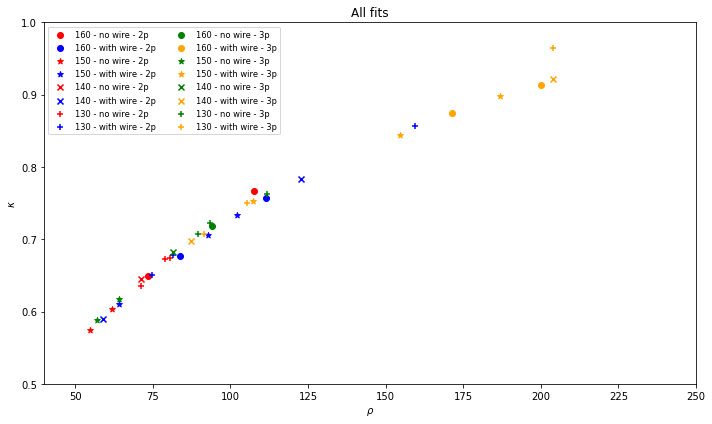

In [186]:
plt.figure(figsize=(10, 6))

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == False) & (best_fits_2_b2["angle"] == 160.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="o", label="160 - no wire - 2p")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == True) & (best_fits_2_b2["angle"] == 160.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="o", label="160 - with wire - 2p")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == False) & (best_fits_2_b2["angle"] == 150.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="*", label="150 - no wire - 2p")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == True) & (best_fits_2_b2["angle"] == 150.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="*", label="150 - with wire - 2p")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == False) & (best_fits_2_b2["angle"] == 140.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="x", label="140 - no wire - 2p")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == True) & (best_fits_2_b2["angle"] == 140.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="x", label="140 - with wire - 2p")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == False) & (best_fits_2_b2["angle"] == 130.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="+", label="130 - no wire - 2p")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == True) & (best_fits_2_b2["angle"] == 130.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="+", label="130 - with wire - 2p")

###############################################################################

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 160.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="g", marker="o", label="160 - no wire - 3p")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 160.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="orange", marker="o", label="160 - with wire - 3p")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 150.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="g", marker="*", label="150 - no wire - 3p")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 150.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="orange", marker="*", label="150 - with wire - 3p")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 140.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="g", marker="x", label="140 - no wire - 3p")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 140.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="orange", marker="x", label="140 - with wire - 3p")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 130.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="g", marker="+", label="130 - no wire - 3p")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 130.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="orange", marker="+", label="130 - with wire - 3p")

plt.xlim(40, 250)
plt.ylim(0.5, 1.0)

plt.legend(ncol=2, fontsize="small")
plt.xlabel("$\\rho$")
plt.ylabel("$\\kappa$")
plt.title("All fits")

plt.tight_layout()

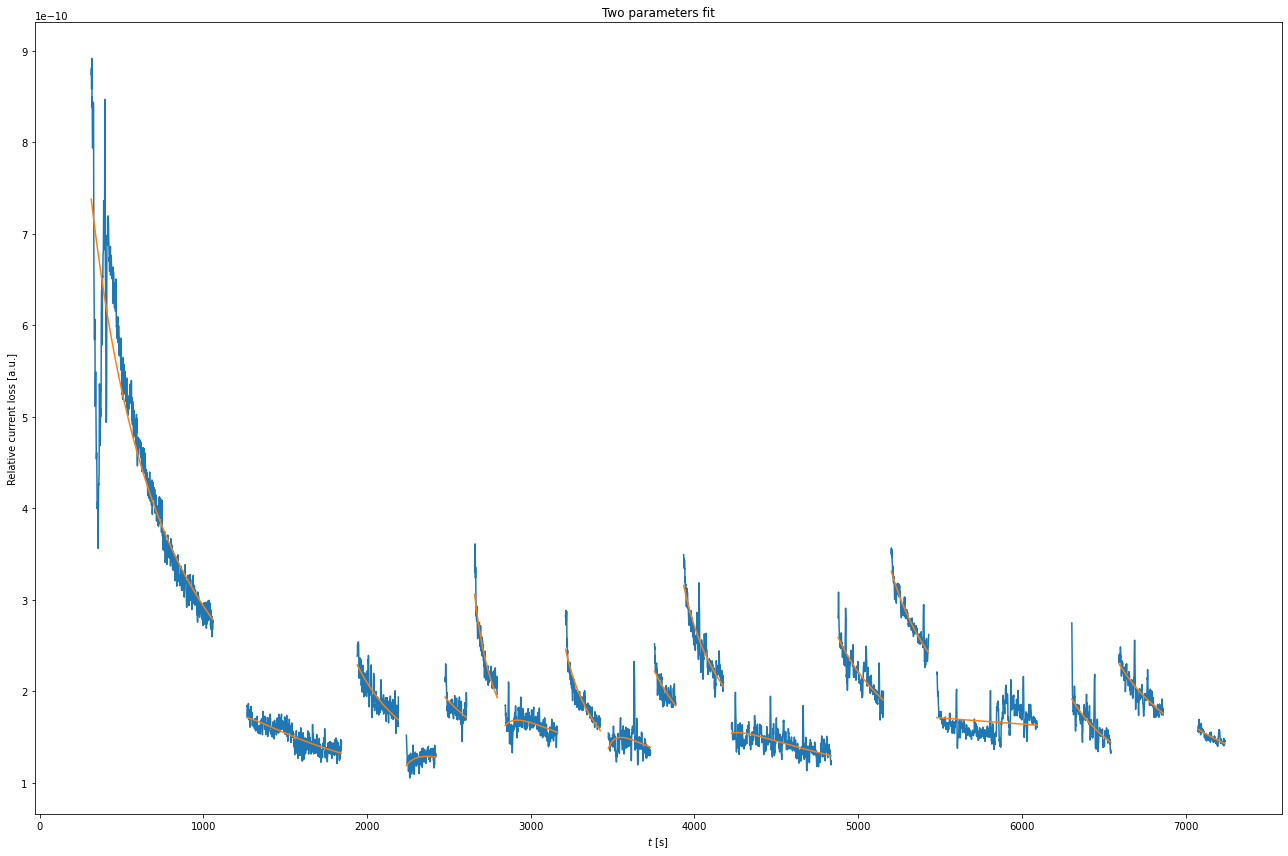

In [187]:
plt.figure(figsize=(18, 12))

for d, f in zip(loss_list_b2, best_fits):
    plt.plot(d.loss_t, f["ydata"], c="C0")
    plt.plot(d.loss_t, f["ydata"] - f['lmfit'].residual, c="C1")

plt.title("Two parameters fit")
plt.xlabel("$t$ [s]")
plt.ylabel("Relative current loss [a.u.]")
plt.tight_layout()

In [51]:
best_fits_3_b2

,wire,angle,rho,kappa,n0,chisq,redchi
0,False,160.0,1.055452e+02,0.761591,8.161401e+04,3.982884e-19,5.411527e-22
1,True,160.0,1.722526e+02,0.876373,2.253934e+06,3.976666e-20,6.252619e-23
2,False,160.0,9.061311e+01,0.708317,2.253934e+06,3.796829e-20,1.356010e-22
3,True,160.0,3.932637e+07,5.727177,6.224689e+07,2.438209e-20,1.074101e-22
4,True,150.0,1.251037e+02,0.788811,1.311134e+05,3.917628e-20,2.238645e-22
5,False,150.0,6.041678e+01,0.601943,5.436184e+05,2.558400e-20,1.650581e-22
6,True,150.0,1.960853e+02,0.912201,1.403004e+06,3.498938e-20,9.940164e-23
7,False,150.0,7.024592e+01,0.639340,8.733262e+05,3.277679e-20,1.400718e-22
8,True,150.0,1.660302e+02,0.863820,8.733262e+05,5.558752e-20,2.066451e-22
9,True,140.0,9.752571e+01,0.723035,5.080218e+04,4.507877e-20,2.699328e-22


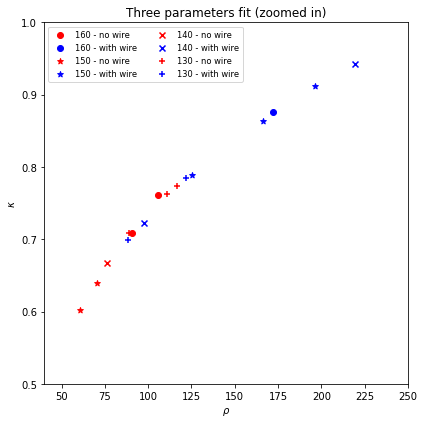

In [52]:
plt.figure(figsize=(6, 6))

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 160.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="o", label="160 - no wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 160.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="o", label="160 - with wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 150.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="*", label="150 - no wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 150.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="*", label="150 - with wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 140.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="x", label="140 - no wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 140.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="x", label="140 - with wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 130.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="+", label="130 - no wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 130.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="+", label="130 - with wire")

plt.legend(ncol=2, fontsize="small")
plt.xlabel("$\\rho$")
plt.ylabel("$\\kappa$")
plt.title("Three parameters fit (zoomed in)")

#plt.xscale("log")
plt.xlim(40, 250)
plt.ylim(0.5, 1.0)
plt.tight_layout()

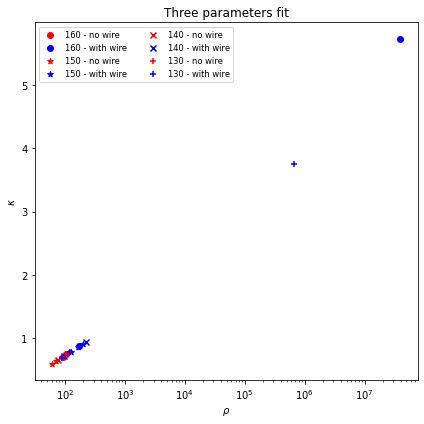

In [53]:
plt.figure(figsize=(6, 6))

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 160.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="o", label="160 - no wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 160.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="o", label="160 - with wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 150.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="*", label="150 - no wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 150.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="*", label="150 - with wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 140.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="x", label="140 - no wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 140.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="x", label="140 - with wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 130.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="+", label="130 - no wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 130.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="+", label="130 - with wire")

plt.legend(ncol=2, fontsize="small")
plt.xlabel("$\\rho$")
plt.ylabel("$\\kappa$")
plt.title("Three parameters fit")

plt.xscale("log")
# plt.xlim(right=1e3)
# plt.ylim(top=1.4)
plt.tight_layout()

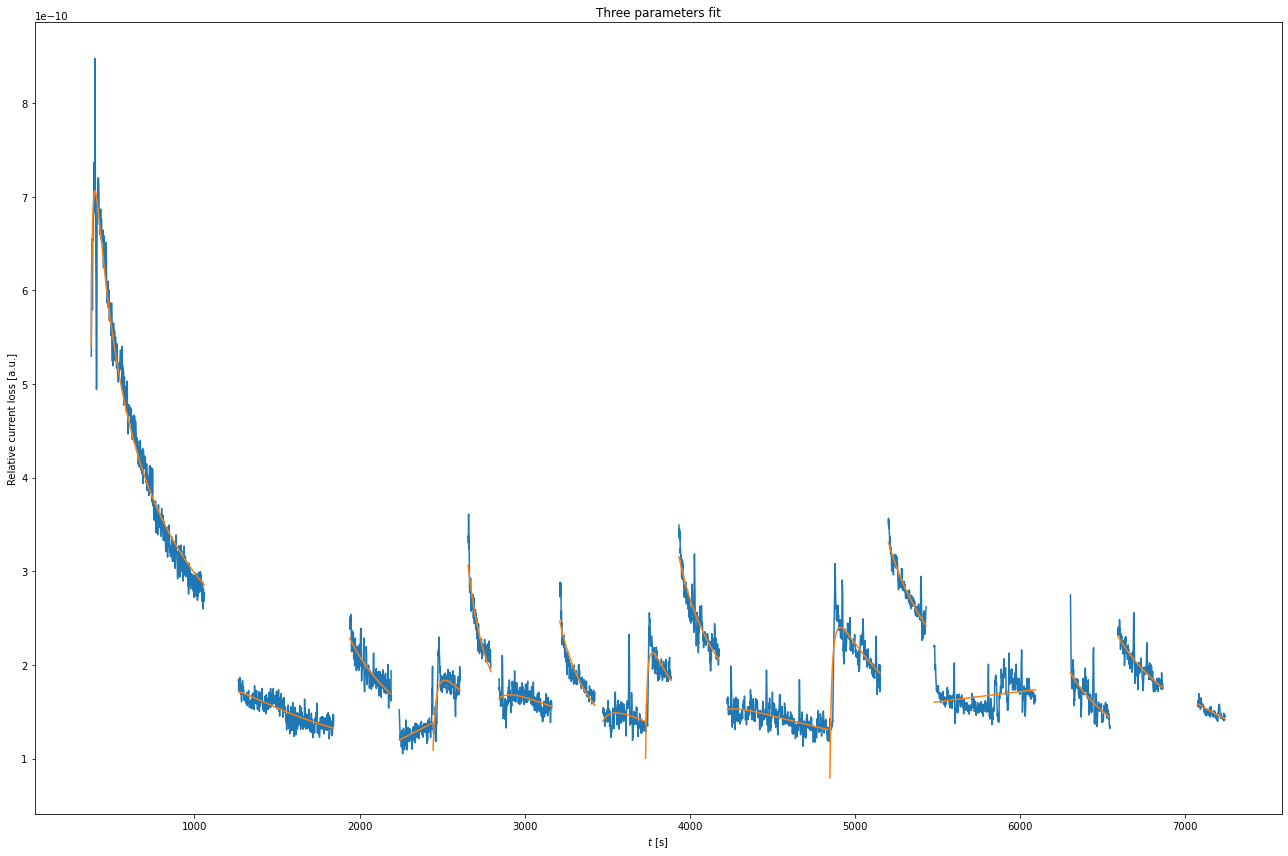

In [54]:
plt.figure(figsize=(18, 12))

for d, f in zip(loss_list_b2, best_fits_3):
    plt.plot(d.loss_t, f["ydata"], c="C0")
    plt.plot(d.loss_t, f["ydata"] - f['lmfit'].residual, c="C1")

plt.title("Three parameters fit")
plt.xlabel("$t$ [s]")
plt.ylabel("Relative current loss [a.u.]")
plt.tight_layout()

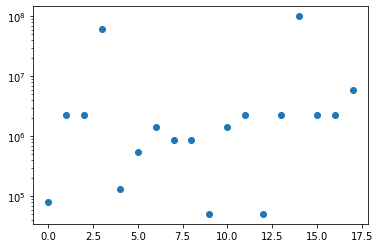

In [55]:
plt.plot(best_fits_3_b2.n0, "o")
plt.yscale("log")

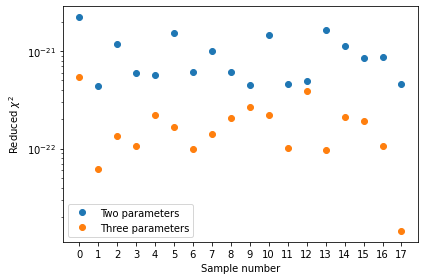

In [66]:
plt.plot(best_fits_2_b2.redchi, "o", label="Two parameters")
plt.plot(best_fits_3_b2.redchi, "o", label="Three parameters")

# set x-ticks as integers
plt.xticks(np.arange(0, len(best_fits_3_b2.n0), 1))

plt.yscale("log")
plt.xlabel("Sample number")
plt.ylabel("Reduced $\\chi^2$")
plt.legend()

plt.tight_layout()

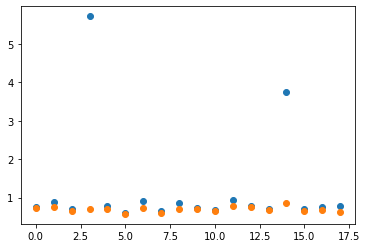

In [57]:
plt.plot(best_fits_3_b2.kappa, "o")
plt.plot(best_fits_2_b2.kappa, "o")

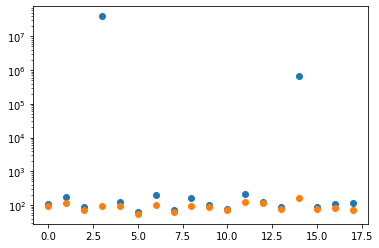

In [58]:
plt.plot(best_fits_3_b2.rho, "o")
plt.plot(best_fits_2_b2.rho, "o")
plt.yscale("log")


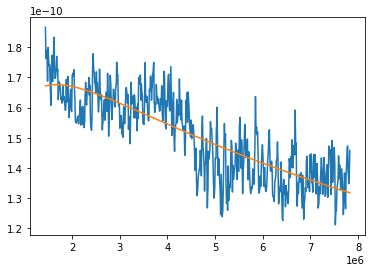

In [89]:
plt.plot(best_fits[1]['xdata'], best_fits[1]['ydata'], label="data")
plt.plot(best_fits[1]['xdata'], best_fits[1]['ydata'] - best_fits[1]['lmfit'].residual, label="residual")

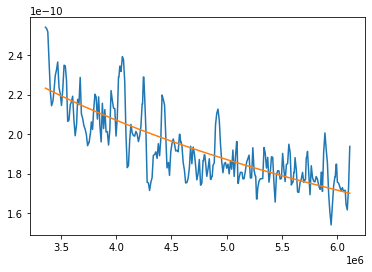

In [90]:
plt.plot(best_fits[2]['xdata'], best_fits[2]['ydata'], label="data")
plt.plot(best_fits[2]['xdata'], best_fits[2]['ydata'] - best_fits[2]['lmfit'].residual, label="residual")

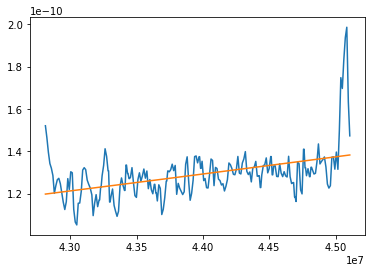

In [91]:
plt.plot(best_fits[3]['xdata'], best_fits[3]['ydata'], label="data")
plt.plot(best_fits[3]['xdata'], best_fits[3]['ydata'] - best_fits[3]['lmfit'].residual, label="residual")

In [94]:
for b in best_fits:
    print(f"rho: {b['rho']}, kappa: {b['kappa']}, n0: {b['n0']}, chisq: {b['chisq']}")

rho: 542.4297734107073, kappa: 1.8181937188735249, n0: 7847599.703514607, chisq: 3.1521254813082085e-19
rho: 167.8189362023891, kappa: 0.8686184018384095, n0: 1438449.888287663, chisq: 3.92083047411488e-20
rho: 79.48589131492923, kappa: 0.6766873454107172, n0: 3359818.286283781, chisq: 3.560901956828893e-20
rho: 2385666.0743422327, kappa: 4.362459820915216, n0: 42813323.98719387, chisq: 2.4408100033167053e-20


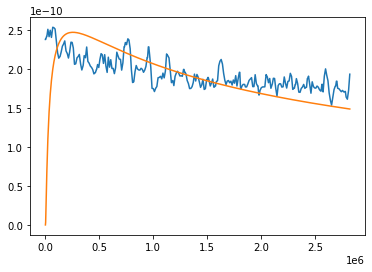

In [106]:
plt.plot(best_fits[2]['xdata'], best_fits[2]['ydata'], label="data")
plt.plot(best_fits[2]['xdata'], best_fits[2]['ydata'] - best_fits[2]['lmfit'].residual, label="residual")

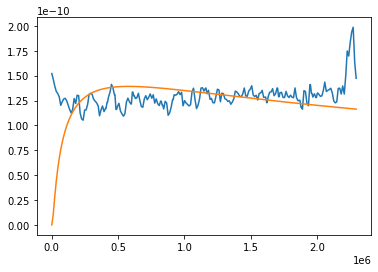

In [107]:
plt.plot(best_fits[3]['xdata'], best_fits[3]['ydata'], label="data")
plt.plot(best_fits[3]['xdata'], best_fits[3]['ydata'] - best_fits[3]['lmfit'].residual, label="residual")

In [108]:
for b in best_fits:
    print(f"rho: {b['rho']}, kappa: {b['kappa']}, n0: {b['n0']}, chisq: {b['chisq']}")

rho: 96.3198990697615, kappa: 0.7371458440126675, n0: 100.0, chisq: 1.637785325549334e-18
rho: 111.40395130662523, kappa: 0.757123298999135, n0: 100.0, chisq: 2.76133001624119e-19
rho: 73.32549872491715, kappa: 0.6483973379240868, n0: 100.0, chisq: 3.3253271486410616e-19
rho: 93.03443066085084, kappa: 0.7047500960642243, n0: 100.0, chisq: 1.354572651122175e-19


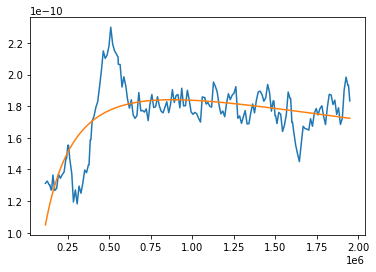

In [188]:
plt.plot(best_fits[0]['xdata'], best_fits[0]['ydata'], label="data")
plt.plot(best_fits[0]['xdata'], best_fits[0]['ydata'] - best_fits[0]['lmfit'].residual, label="residual")

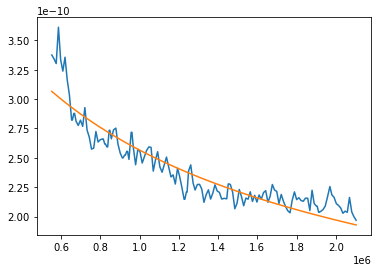

In [189]:
plt.plot(best_fits[1]['xdata'], best_fits[1]['ydata'], label="data")
plt.plot(best_fits[1]['xdata'], best_fits[1]['ydata'] - best_fits[1]['lmfit'].residual, label="residual")

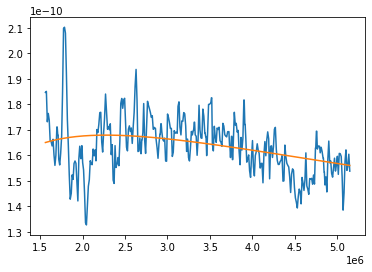

In [190]:
plt.plot(best_fits[2]['xdata'], best_fits[2]['ydata'], label="data")
plt.plot(best_fits[2]['xdata'], best_fits[2]['ydata'] - best_fits[2]['lmfit'].residual, label="residual")

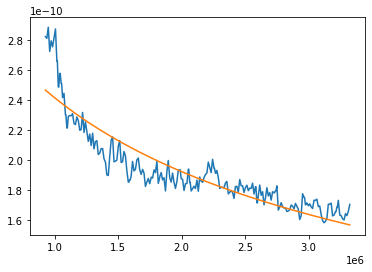

In [191]:
plt.plot(best_fits[3]['xdata'], best_fits[3]['ydata'], label="data")
plt.plot(best_fits[3]['xdata'], best_fits[3]['ydata'] - best_fits[3]['lmfit'].residual, label="residual")

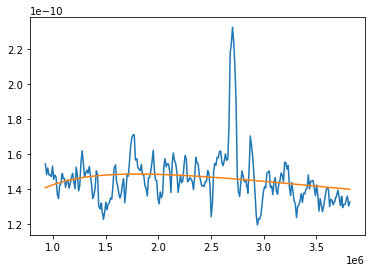

In [192]:
plt.plot(best_fits[4]['xdata'], best_fits[4]['ydata'], label="data")
plt.plot(best_fits[4]['xdata'], best_fits[4]['ydata'] - best_fits[4]['lmfit'].residual, label="residual")